In [9]:
from LDPC_decoder import Decoder
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os    
import math
import galois
import itertools
import random
import pickle

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


In [10]:
def save_q_table(q_table, filename="q_table.pkl"):
    """
    Save Q-table to a file using pickle.
    """
    with open(filename, "wb") as f:
        pickle.dump(dict(q_table), f)  # Convert defaultdict to dict before saving


In [11]:
def quantize(s, bins):
    """
    Discretizes a continuous state vector into bins.
    
    Args:
        s (np.ndarray): Continuous state vector with values between -1 and 1
        bins (int): Number of discrete bins per dimension
    
    Returns:
        tuple: Discretized state indices as a tuple
    """
    clamped = np.clip(s, -1, 1)
    indices = []
    bin_width = 2 / bins
    for value in clamped:
        index = int((value + 1) / bin_width)
        index = min(index, bins - 1)  # Ensure we stay within bounds
        indices.append(index)
    return tuple(indices)


def dequantize(disc_s, bins):
    """
    Converts a discretized state back to continuous space (midpoint of bins).
    
    Args:
        disc_s (tuple): Discretized state indices
        bins (int): Number of discrete bins per dimension used in quantization
    
    Returns:
        np.ndarray: Continuous state vector approximation
    """
    continuous = []
    bin_width = 2 / bins
    for index in disc_s:
        midpoint = -1 + (index + 0.5) * bin_width
        continuous.append(midpoint)
    return np.array(continuous)


In [12]:
class QLearningAgent:
    def __init__(self, n, bins, alpha=0.1, gamma=0.99, epsilon=1.0, 
                 epsilon_decay=0.995, epsilon_min=0.01):  # Add decay parameters
        self.n = n
        self.bins = bins
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay  # New parameter
        self.epsilon_min = epsilon_min      # New parameter
        self.q_table = defaultdict(lambda: np.zeros(n))

    def decay_epsilon(self):  # New method
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def get_action(self, disc_s):
        """Epsilon-greedy policy"""
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n)
        return np.argmax(self.q_table[disc_s])

    def update_q_table(self, disc_s, action, reward, disc_s_prime):
        """Q-learning update rule"""
        current_q = self.q_table[disc_s][action]
        max_future_q = np.max(self.q_table[disc_s_prime])
        new_q = current_q + self.alpha * (reward + self.gamma * max_future_q - current_q)
        self.q_table[disc_s][action] = new_q

def train_agent(agent, blackbox, episodes=1000, steps_per_episode=100,
                track_state=None, track_action=None, H=None, C=None, cluster_size=1):
    """
    Modified training loop with metrics collection
    """
    # Initialize metrics storage
    metrics = {
        'episode_rewards': [],
        'avg_q_values': [],
        'exploration_rate': [],
        'unique_states': [],
        'td_errors': [],
        'tracked_q': []
    }

    # Convert tracked state to discrete representation
    if track_state is not None:
        disc_track_state = quantize(track_state, agent.bins)
    else:
        disc_track_state = None


    for episode in range(episodes):
        if state_definition=="pseudo-difference" or state_definition=="difference":
            state = np.random.uniform(-1, 1, size=agent.n)
        else:
            state = np.random.uniform(0,1,size=agent.n)
        
        disc_state = quantize(state, agent.bins)
        episode_reward = 0
        episode_td_errors = []
        visited_states = set()

        snrdb = 1.5
        c = C[np.random.choice(len(C))] # correct codeword
        dec = initialize_ldpc_decoder(H, snrdb, c, steps_per_episode, cluster_size)
        if disc_track_state is not None and track_action is not None:
            current_q = agent.q_table[disc_track_state][track_action]
            metrics['tracked_q'].append(current_q)
        else:
            metrics['tracked_q'].append(None)

        c = C[np.random.choice(len(C))] # correct codeword

        for _ in range(steps_per_episode):
            action = agent.get_action(disc_state)
            next_state, reward = blackbox(dec, c, state, action)
            disc_next_state = quantize(next_state, agent.bins)
            
            # Store pre-update Q-value for TD error calculation
            old_q = agent.q_table[disc_state][action]
            
            # Update Q-table
            agent.update_q_table(disc_state, action, reward, disc_next_state)
            
            # Calculate TD error
            new_q = agent.q_table[disc_state][action]
            td_error = abs(new_q - old_q)
            episode_td_errors.append(td_error)
            
            # Update metrics
            episode_reward += reward
            visited_states.add(disc_state)
            
            # Transition to next state
            state = next_state
            disc_state = disc_next_state

        print(f"EPISODE {episode} : episode_reward = {episode_reward}\t\t td-error = {np.mean(episode_td_errors)}")
        agent.decay_epsilon()  
        # Store episode metrics
        metrics['episode_rewards'].append(episode_reward)
        metrics['avg_q_values'].append(np.mean(list(agent.q_table.values())))
        metrics['exploration_rate'].append(agent.epsilon)
        metrics['unique_states'].append(len(visited_states))
        metrics['td_errors'].append(np.mean(episode_td_errors))

        # Optional: Add epsilon decay
        # agent.epsilon *= 0.995

    return metrics


In [13]:
def plot_metrics(metrics, window=100):
    """Plot all convergence metrics"""
    plt.figure(figsize=(15, 10))
    
    # Cumulative Reward
    plt.subplot(2, 3, 1)
    plt.plot(metrics['episode_rewards'])
    plt.plot(np.convolve(metrics['episode_rewards'], np.ones(window)/window, mode='valid'))
    plt.title('Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    
    # Average Q-Values
    plt.subplot(2, 3, 2)
    plt.plot(metrics['avg_q_values'])
    plt.title('Average Q-Values')
    plt.xlabel('Episode')
    plt.ylabel('Average Q-value')
    
    # TD Errors
    plt.subplot(2, 3, 3)
    plt.plot(metrics['td_errors'])
    plt.title('TD Errors')
    plt.xlabel('Episode')
    plt.ylabel('Average TD Error')
    
    # Exploration Rate
    plt.subplot(2, 3, 4)
    plt.plot(metrics['exploration_rate'])
    plt.title('Exploration Rate')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    
    # Unique States Visited
    plt.subplot(2, 3, 5)
    plt.plot(metrics['unique_states'])
    plt.title('Unique States Visited')
    plt.xlabel('Episode')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()



def plot_tracked_q(metrics, episodes, title=""):
    plt.figure()
    plt.plot(range(episodes), metrics['tracked_q'])
    plt.title(f"Q-value Convergence {title}")
    plt.xlabel("Episode")
    plt.ylabel("Q-value")
    plt.grid(True)
    plt.show()



## Environment for the RL agent

In [ ]:
# # Define a dummy blackbox environment for demonstration
# def dummy_blackbox(s, a):
#     """Example environment that moves towards action dimension"""
#     s_prime = s.copy()
#     s_prime[a] += np.random.normal(0, 0.1)  # Add noise to selected dimension
#     s_prime = np.clip(s_prime, -1, 1)       # Maintain state bounds
#     reward = np.sum(s_prime)                # Simple reward function
#     return s_prime, reward


# def gridworld_blackbox(s, a):
#     """
#     Simple n-dimensional navigation task where:
#     - State represents position in hypercube [-1,1]^n
#     - Agent must reach target state near origin
#     - Actions move in coordinate directions with noise
#     """
#     target_radius = 0.1
#     movement_scale = 0.2  # Max movement per action
#     n = len(s)
    
#     # Create movement vector with noise
#     delta = np.zeros(n)
#     delta[a] = movement_scale * np.random.normal(1, 0.3)  # Biased movement in action direction
    
#     # Calculate new state with bounds checking
#     s_prime = np.clip(s + delta, -1, 1)
    
#     # Calculate distance-based reward
#     # distance = np.linalg.norm(s_prime)
#     # target_bonus = 10.0 if distance < target_radius else 0.0
#     # reward = -distance + target_bonus  # Reward agent for getting closer
    
#     distance = np.linalg.norm(s_prime)
#     reward = -0.5 * distance + 10.0 * (distance < target_radius)

#     # Optional: Reset state when target reached
#     if distance < target_radius:
#         s_prime = np.random.uniform(-0.8, 0.8, size=n)
        
#     return s_prime, reward

state_definition = "MI"
state_definition = "difference"
state_definition = "pseudo-difference"

def ldpc_decoder(dec, c, s, a):
    # input is s = state and a = action
    # function performs scheduling of cluster 'a' give state is 's' and returns the reward
    # assumes initialization of decoder is already done

    # performing action 'a' on state 's'
    # currentMI = s
    dec.row_update(a)
    dec.col_update(a)
    dec.MI = dec.get_MI(dec.L)
    newMI = dec.MI
    c_hat = np.array([1 if val<0 else 0 for val in dec.sum])


    # finding out next state (depending upon state definition)
    if state_definition=="MI":
        s_prime = newMI
    elif state_definition=="difference":
        s_prime = newMI-s
    elif state_definition=="pseudo-difference":
        s_prime = np.zeros(len(s))
        for a in range(len(s)):
            p_L, p_sum = dec.pseudo_row_update(a)
            pseudo_MI = dec.get_MI(p_L)
            s_prime[a] = pseudo_MI[a]-newMI[a]
    


    # calculating reward (based on reward definition)
    # reward = (np.sum(c == c_hat)/len(c)) # fraction of correct codebits
    # reward = -1/(1e-4+np.sum(dec.MI)) # negative inverse sum of MI
    # reward = np.sum(dec.MI) # direct sum of MI (better/more stable than neg-inv sum)
    reward = (s_prime-s)[a] # difference observed in ath cluster's MI
    # reward = np.mean(newMI-currentMI) # average increase in MI after scheduling
    

    return s_prime, reward


def initialize_ldpc_decoder(H, snrdb, c, num_iter, cluster_size):
    snr = math.pow(10,snrdb/20)
    sigma = 1/math.sqrt(snr)
    y = np.power(- 1,c) + np.random.normal(loc=0, scale=sigma, size=c.shape)

    dec = Decoder(H,num_iter,cluster_size, clusters=None)
    dec.sum = y
    dec.L = np.full(dec.H.shape, np.nan, dtype=float)
    for i in range(dec.num_CN):
        for j in range(dec.num_VN):
            dec.L[i,j] = 0 if dec.H[i,j]==1 else np.nan
    dec.MI = dec.get_MI(dec.L)

    return dec



## Parameters for LDPC code

In [15]:
def circular_shift_identity(z, k):
    if k == -1:
        return np.zeros((z, z), dtype=int)
    else:
        return np.roll(np.eye(z, dtype=int), -k, axis=1)

def expand_base_matrix(B, z):
    m, n = B.shape
    H = np.zeros((m * z, n * z), dtype=int)  # Full parity check matrix initialized to zeros

    for i in range(m):
        for j in range(n):
            # Expand each base matrix element into a z x z block
            block = circular_shift_identity(z, B[i, j])
            H[i * z:(i + 1) * z, j * z:(j + 1) * z] = block

    return H

def get_codewords(H):
    GF = galois.GF(2)
    A = GF(H)
    N = A.null_space()
    vec = [np.array(v) for v in itertools.product([0, 1], repeat=N.shape[0])]
    C = np.array(GF(vec) @ N)
    return C


# B = np.array([
#     [0, 1, -1, -1, -1, -1, -1, -1, -1, -1],
#     [-1, 0, 1, -1, -1, -1, -1, -1, -1, -1],
#     [1, -1, 2, -1, 3, -1, 4, -1, 5, -1],
#     [-1, 2, -1, 3, -1, 4, -1, 5, -1, 0],
#     [3, -1, 4, -1, 5, -1, 0, -1, 1, -1],
#     [-1, 4, -1, 5, -1, 0, -1, 1, -1, 2],
#     [5, -1, 0, -1, 1, -1, 2, -1, 3, -1],
#     [-1, 0, -1, 1, -1, 2, -1, 3, -1, 4]
# ])

# print("B = \n",B)
# z = 5

# H = expand_base_matrix(B,z)
# np.savetxt('output.txt',H,fmt="%d")
# print("H : \n",H)

# C = get_codewords(H)
# print("Codewords : \n",C)
# print(len(C)," codewords found")
# dmin = np.min(np.sum(C[1:],axis=1))
# print("dmin = ",dmin)

# print("Shape of H : ",H.shape)


# B = np.array([[0,2,-1,3,-1,-1,2,4,1,0],
#             [3,1,-1,-1,0,0,1,2,3,0],
#             [1,0,0,-1,1,4,2,1,0,-1],
#             [-1,0,0,2,3,-1,-1,-1,0,-1],
#             [1,0,2,0,1,0,-1,-1,-1,-1],
#             [2,1,0,0,2,-1,-1,-1,1,-1]]
#             ,dtype=int)

B = np.array([  [0, 2, -1, 3, 0, 0,-1, -1, -1, -1],
                [3, 1, -1,-1, 1, 0, 0, -1, -1, -1],
                [1, -1, 2, -1, 0,-1, 0, -1, -1, -1],
                [-1, 1, -1, 2, 3, -1,-1,  0, -1, -1],
                [2, -1, 2, 0, -1,  0,-1, -1,  0, -1],
                [1, -1, 4, 0, 2, -1, 3, -1, -1,  0]]
                ,dtype=int)

# B = np.array([[-1,0,1],
#              [1,0,2]],dtype=int)
print("B = \n",B)
z = 5

H = expand_base_matrix(B,z)
np.savetxt('output.txt',H,fmt="%d")
print("H : \n",H)

C = get_codewords(H)
print("Codewords : \n",C)
print(len(C)," codewords found")
dmin = np.min(np.sum(C[1:],axis=1))
print("dmin = ",dmin)
print("shape of H : ",H.shape)


B = 
 [[ 0  2 -1  3  0  0 -1 -1 -1 -1]
 [ 3  1 -1 -1  1  0  0 -1 -1 -1]
 [ 1 -1  2 -1  0 -1  0 -1 -1 -1]
 [-1  1 -1  2  3 -1 -1  0 -1 -1]
 [ 2 -1  2  0 -1  0 -1 -1  0 -1]
 [ 1 -1  4  0  2 -1  3 -1 -1  0]]
H : 
 [[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 1 0 ... 1 0 0]
 [0 0 1 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
Codewords : 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 0]
 ...
 [1 1 1 ... 0 1 1]
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 1]]
1048576  codewords found
dmin =  7
shape of H :  (30, 50)


In [16]:
B = np.array([[0,2,-1,3,-1,-1,2,4,1,0],
            [3,1,-1,-1,0,0,1,2,3,0],
            [1,0,0,-1,1,4,2,1,0,-1],
            [-1,0,0,2,3,-1,-1,-1,0,-1],
            [1,0,2,0,1,0,-1,-1,-1,-1],
            [2,1,0,0,2,-1,-1,-1,1,-1]]
            ,dtype=int)

# B = np.array([[-1,0,1],
#              [1,0,2]],dtype=int)
print("B = \n",B)
z = 5

H = expand_base_matrix(B,z)
np.savetxt('output.txt',H,fmt="%d")
print("H : \n",H.shape)

C = get_codewords(H)
print("Codewords : \n",C)
print(len(C)," codewords found")
dmin = np.min(np.sum(C[1:],axis=1))
print("dmin = ",dmin)

B = 
 [[ 0  2 -1  3 -1 -1  2  4  1  0]
 [ 3  1 -1 -1  0  0  1  2  3  0]
 [ 1  0  0 -1  1  4  2  1  0 -1]
 [-1  0  0  2  3 -1 -1 -1  0 -1]
 [ 1  0  2  0  1  0 -1 -1 -1 -1]
 [ 2  1  0  0  2 -1 -1 -1  1 -1]]
H : 
 (30, 50)
Codewords : 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
1048576  codewords found
dmin =  9


In [ ]:
num_iter = 150
cluster_size = 15
num_episodes = 1000

STATE_DIM = math.ceil(H.shape[0]/cluster_size)  # 2D for easy visualization
BINS = 100    # Discretization resolution
example_state = np.array([0.017, 0.054])  # State to track
example_action = 1                     # Action to track 


# Create and train agent
agent = QLearningAgent(
    n=STATE_DIM,
    bins=BINS,
    alpha=0.15,
    gamma=0.9,
    epsilon=1.0,        # Start with full exploration
    epsilon_decay=1, # Decay rate (0.99 = 1% decay per episode)
    epsilon_min=0.01    # Minimum exploration probability
)

print(f"state-definition : {state_definition}\nSTATE-DIM : {STATE_DIM}\nBINS : {BINS}")
metrics = train_agent(agent, ldpc_decoder, 
                        episodes=num_episodes,
                        track_state=example_state,
                        track_action=example_action,
                        steps_per_episode=num_iter,
                        H=H,
                        C=C,
                        cluster_size=cluster_size)



state-definition : pseudo-difference
STATE-DIM : 2
BINS : 100
EPISODE 0 : episode_reward = -0.2692402853606548		 td-error = 0.0014663980262466163
EPISODE 1 : episode_reward = 0.5612848875228507		 td-error = 0.001203748348029176
EPISODE 2 : episode_reward = 0.5438181596696087		 td-error = 0.0015455718121855336
EPISODE 3 : episode_reward = -0.7749414319396152		 td-error = 0.0016061758726108977
EPISODE 4 : episode_reward = 0.4557772070930941		 td-error = 0.0016389570593327817
EPISODE 5 : episode_reward = 0.06429041585900097		 td-error = 0.0005018075146384541
EPISODE 6 : episode_reward = -0.44039620261898405		 td-error = 0.0016099449308722969
EPISODE 7 : episode_reward = -0.5457185592977234		 td-error = 0.001050634424742397
EPISODE 8 : episode_reward = 0.07316012708299224		 td-error = 0.0016616746020289839
EPISODE 9 : episode_reward = -0.8713185984161507		 td-error = 0.0014420865092545747
EPISODE 10 : episode_reward = -0.8255490608781911		 td-error = 0.002087108123477978
EPISODE 11 : episo

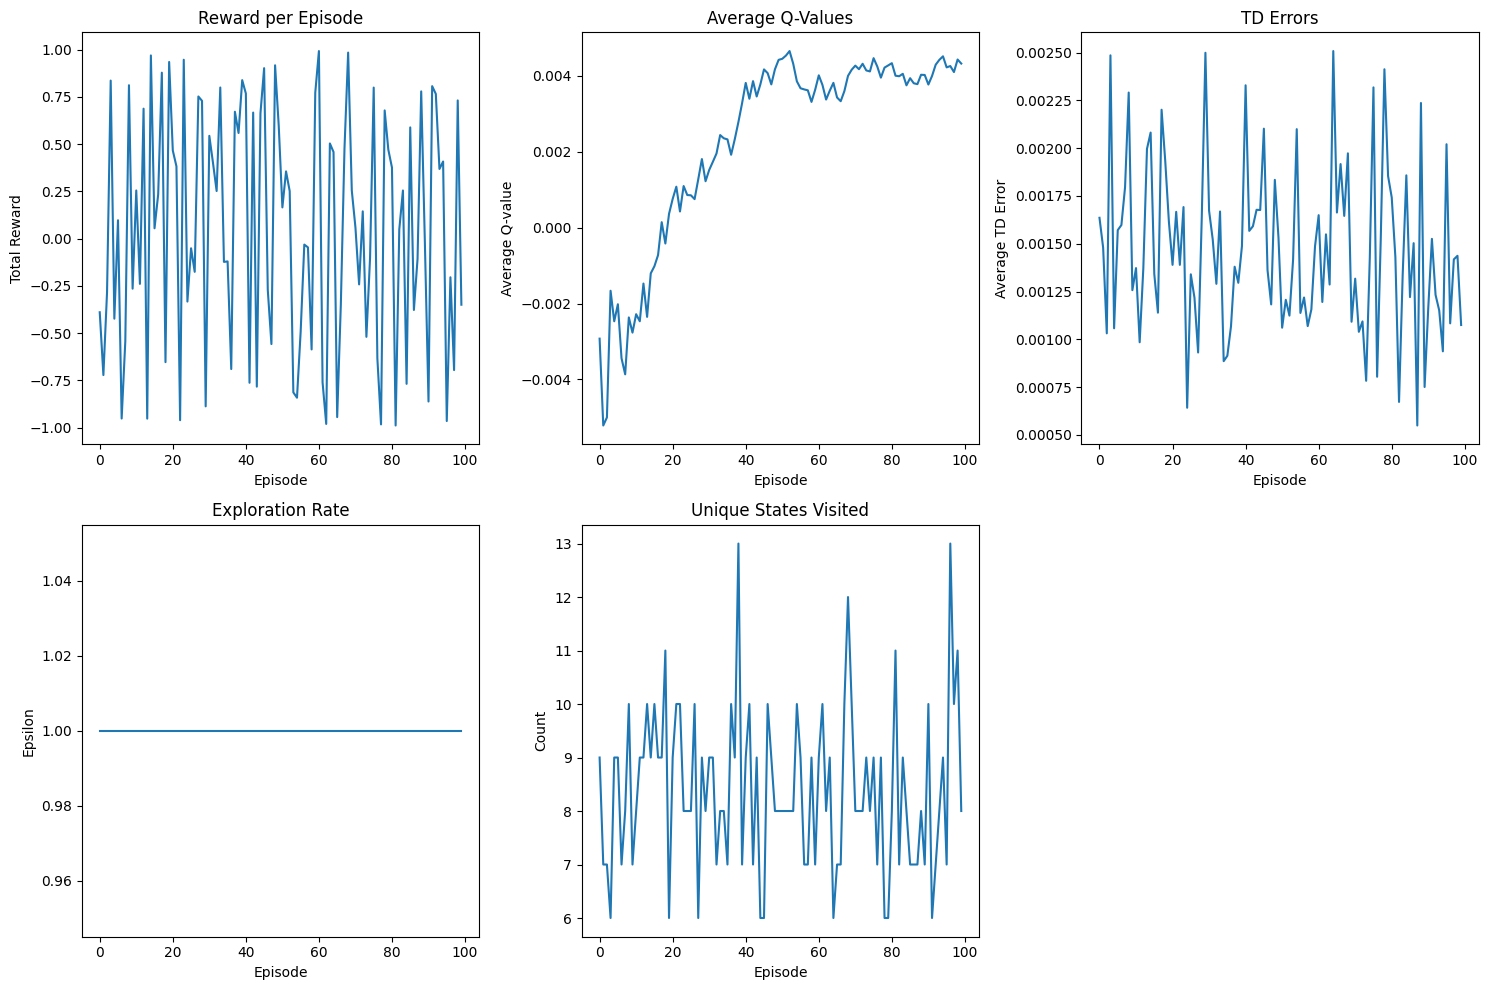

In [20]:
plot_metrics(metrics)
save_q_table(agent.q_table, "trained_q_table.pkl")

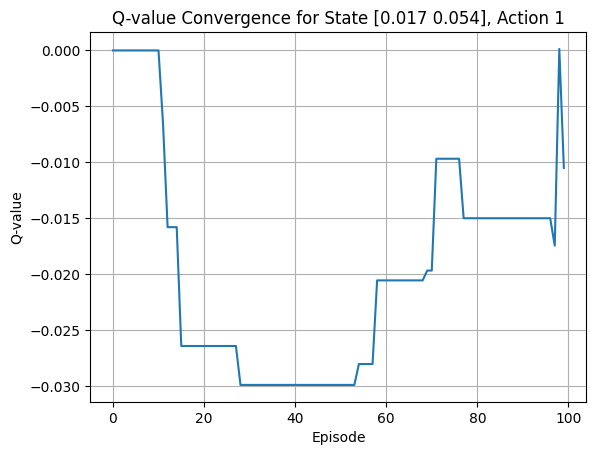

In [21]:
plot_tracked_q(metrics, episodes=num_episodes, 
                title=f"for State {example_state}, Action {example_action}")


In [22]:
# print(agent.q_table[0.1,0.8][0])
# print(type(agent.q_table))
s = np.array([0.8,0.1])
s_q = quantize(s, agent.bins)
a = 1

for k in range(100):
    if state_definition=="MI":
        s =  np.random.rand(STATE_DIM)
    elif state_definition=="pseudo-difference" or state_definition=="difference":
        s = 2 * np.random.rand(STATE_DIM) - 1
    s_q = quantize(s,agent.bins) 
    # a1 =  random.randint(0, STATE_DIM - 1)
    # a2 =  random.randint(0, STATE_DIM - 1)
    a1 = 0
    a2 = 1
    q_val1 = agent.q_table[s_q][a1]
    q_val2 = agent.q_table[s_q][a2]

    print(f"state = {s} action = {a1,a2} q_val = {q_val1,q_val2}")



# print(agent.q_table[s_q][a])

state = [0.75957458 0.47862596] action = (0, 1) q_val = (0.0, 0.0)
state = [ 0.49782504 -0.1457744 ] action = (0, 1) q_val = (0.0, 0.0)
state = [0.28933605 0.24445669] action = (0, 1) q_val = (0.0, 0.0)
state = [-0.05716573  0.32898304] action = (0, 1) q_val = (0.0, 0.0)
state = [0.01629479 0.36525153] action = (0, 1) q_val = (0.0, -0.10280252329368089)
state = [-0.56043914  0.17160537] action = (0, 1) q_val = (0.0, 0.0)
state = [ 0.43375109 -0.79631075] action = (0, 1) q_val = (0.0, 0.0)
state = [-0.06373986  0.4154905 ] action = (0, 1) q_val = (0.0, 0.0)
state = [ 0.84306145 -0.30517963] action = (0, 1) q_val = (0.0, 0.0)
state = [-0.74346379  0.1380791 ] action = (0, 1) q_val = (0.0, 0.0)
state = [ 0.19189372 -0.02750812] action = (0, 1) q_val = (0.0, 0.0)
state = [-0.67101801 -0.34538096] action = (0, 1) q_val = (0.0, 0.0)
state = [ 0.12361535 -0.82780485] action = (0, 1) q_val = (0.0, 0.0)
state = [-0.8089787  -0.69870818] action = (0, 1) q_val = (0.0, 0.0)
state = [ 0.57011447 -0

### General Observations

- If number of bins is large, more number of episodes are required during training so that each possible state is explored enough for its q-values to converge. 
- Learning rate is unconventionally high in these settings (check)
- Look into rewards def (include temporal aspect or discount rewards by time or something like this... ) and try to get average rewards converge. (also td errors)


### For reward as fraction of correct codebits
- For above set of parameters, 300 eps, 10 bins, 0.15 lr, for a fixed state, we get higher q-values for cluster currently having lower MI and vice versa. This makes sense as if a cluster has lower MI, it is likely to give a higher increase in MI if scheduled.

### For reward as the sum of MI vector after scheduling
- For this definition, same setting as above, we observe the same. For states having similar values of MI for both clusters, the q-values are also similar (agrees with theory)

### For reward as the increase in MI of the scheduled cluster 
- The same observations seen here for the same settings, but best out of all. (very few to nill exceptional cases)
- This idea captures the greedy strategy of scheduling cluster which gives max increase in MI of that cluster
 
### For reward as the net/avg increase in MI
- This also follows the same observation but convergence of average of q-table is smoother, but for many states, actions have similar q-values (even though states vastly differ, not observed in prev versions)


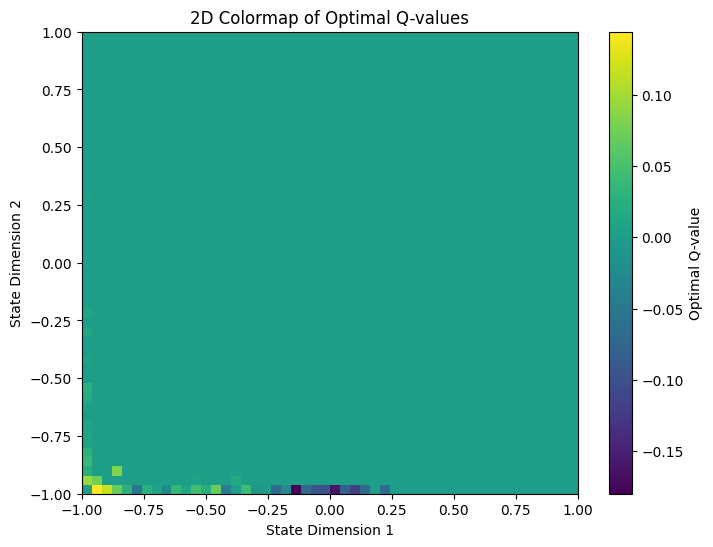

In [24]:
# agent.bins for quantizing states
bins = [np.linspace(-1, 1, agent.bins) for _ in range(2)]  # Example state space
# Create a grid of all possible states
if state_definition=="MI":
    state1_vals = np.linspace(0, 1, agent.bins)
    state2_vals = np.linspace(0, 1, agent.bins)
else:
    state1_vals = np.linspace(0, 1, agent.bins)
    state2_vals = np.linspace(0, 1, agent.bins)

optimal_q_values = np.zeros((agent.bins, agent.bins))

# Calculate the optimal Q-value for each state in the grid
for i, s1 in enumerate(state1_vals):
    for j, s2 in enumerate(state2_vals):
        # Quantize the state
        s_q = quantize(np.array([s1, s2]), agent.bins)
        # Get the maximum Q-value for the quantized state across all actions
        optimal_q_values[i, j] = np.max(agent.q_table[s_q[0], s_q[1]])

# Plot the 2D colormap
plt.figure(figsize=(8, 6))
plt.imshow(optimal_q_values, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label='Optimal Q-value')
plt.xlabel('State Dimension 1')
plt.ylabel('State Dimension 2')
plt.title('2D Colormap of Optimal Q-values')
plt.show()
